# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

# Setup

In [45]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [46]:
model.find_ss(do_print=True)

Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5000000074505806 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5000000074505806
Q = 0.5 M_L = 0.5 beta =  0.9875000147148967 N_L = 0.5
Q = 0.5000000074505806 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5555288886237749 M_L = 0.29336502449307045 beta =  0.9904701503796588 N_L = 0.07653419793179767
Q = 0.5991756370762542 M_L = 0.30846487474343526 beta =  0.989423997210302 N_L = 0.3221091629527982
Q = 0.6118469478754717 M_L = 0.3026867407924191 beta =  0.9896435822085792 N_L = 0.22569627717342505
Q = 0.6479030207012346 M_L = 0.31629464473514796 beta =  0.9899565048659957 N_L = 0.17715704494982626
Q = 0.6644721368796703 M_L = 0.3082944994028017 beta =  0.99018020059357 N_L = 0.17603706921109702
Q = 0.6644721368796703 M_L = 0.30829450399674774 beta =  0.99018020059357 N_L = 0.17603706921109702
Q = 0.6644721368796703 M_L = 0.3082944

In [ ]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.6 secs [533 iterations]


In [ ]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## Policy functions

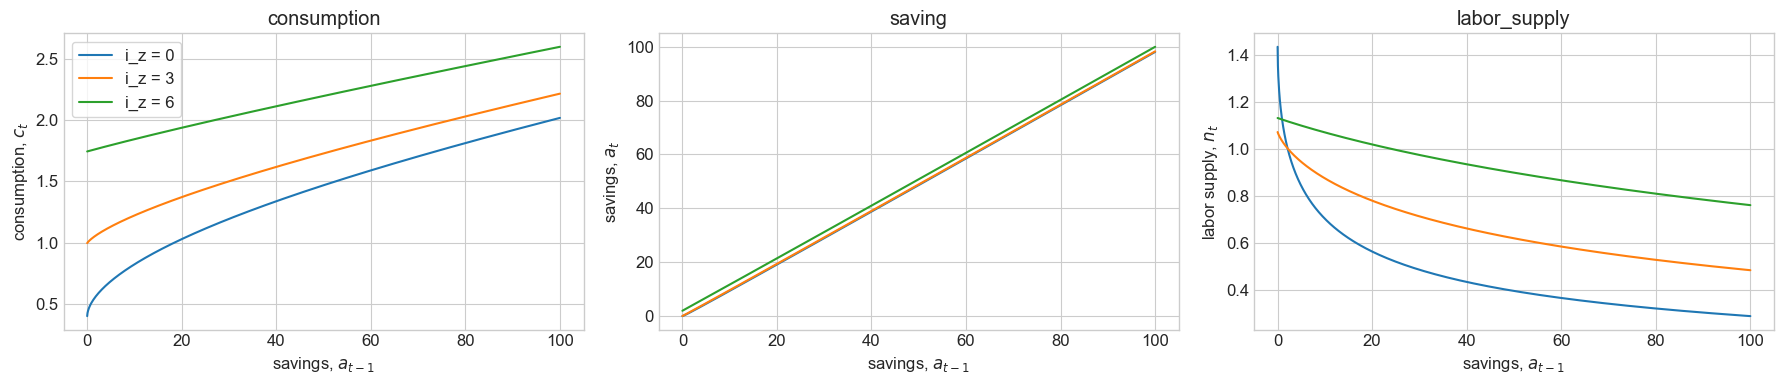

In [ ]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [ ]:
print("Steady state W_L, W_N, Q = ", ss.w_L, ss.w_N, ss.Q)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
#print("Steady state interest rate", ss.r)
print("steady state consumption C", ss.C_hh,"C_L", ss.C_L_hh,"C_N", ss.C_N_hh)
#print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state W_L, W_N, Q =  1.2557431681629494 1.0384687454261814 0.8269754291758378
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.599999999968318 0.0
steady state consumption C 1.104476248990925 C_L 0.35138585730783983 C_N 0.30166262334543553
varphi=  0.8 beta =  0.9863792322155789


## Simulation

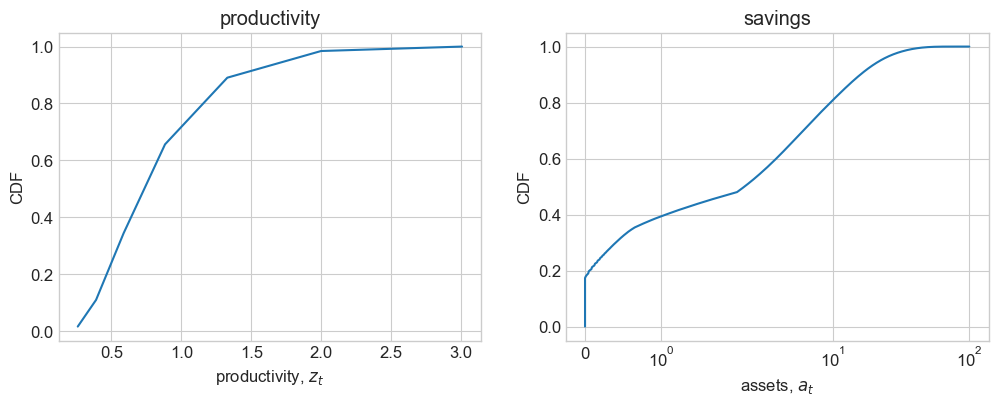

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.7 secs
household problem simulated along transition in 2.3 secs



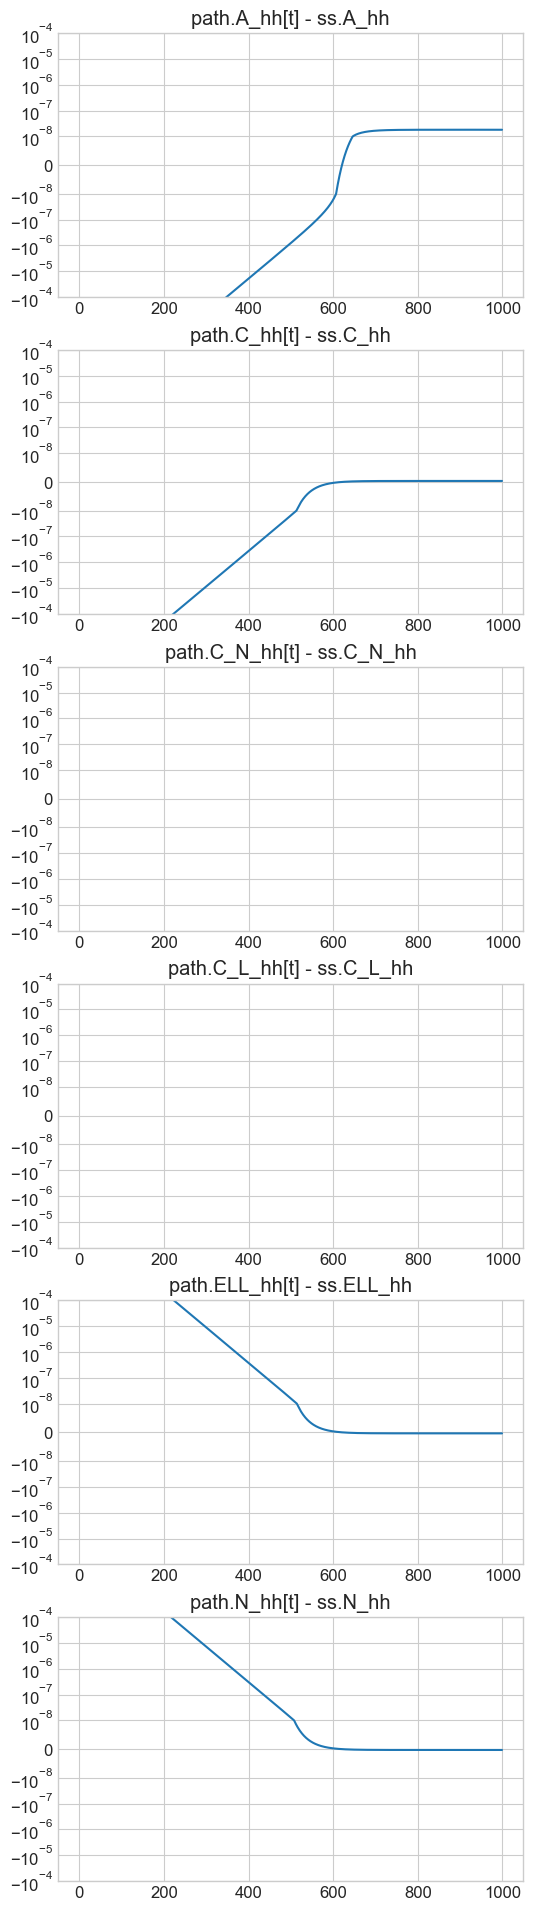

In [16]:
model.test_hh_path()

**Full transition path:**

In [17]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors



TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'M' of type PathClass(array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 4d, C), array(float64, 3d, C), array(float64, 4d, C), array(float64, 4d, C), array(int32, 4d, C), array(float64, 4d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C), array(float64, 2d, C))
[1m
File "blocks.py", line 31:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        N_L = path.N[ncol,:]
[1m        M = path.M[ncol,:]
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\Johan\OneDrive\Økonomi KU\Speciale\GitHub Repositories\hank-speciale\two_sector\blocks.py (31)[0m
[1m
File "blocks.py", line 31:[0m
[1mdef block_pre(par,ini,ss,path,ncols=1):
    <source elided>
        N_L = path.N[ncol,:]
[1m        M = path.M[ncol,:]
[0m        [1m^[0m[0m


In [ ]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [ ]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

## Plot transitions

In [ ]:
paths = ['i','pi_L','pi_N','r','C']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()